In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
import json
import isodate
from apiclient.discovery import build
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV

In [16]:
df = pd.read_csv('MarquesBrownlee_cleaned.csv')

In [17]:
df.drop(columns = ['season_0.1','season_1.1','season_3.1','day_part_0.1','day_part_1.1' ,'day_part_3.1', 'Unnamed: 0'], inplace = True)

In [19]:
X = df.drop(columns = ['view_count'])
y = df['view_count']

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 19 columns):
comment_count            1112 non-null int64
duration                 1112 non-null int64
days_after_last_video    1112 non-null int64
title_length             1112 non-null int64
description_length       1112 non-null int64
tag_count                1112 non-null int64
weekend                  1112 non-null int64
season_0                 1112 non-null int64
season_1                 1112 non-null int64
season_3                 1112 non-null int64
day_part_0               1112 non-null int64
day_part_1               1112 non-null int64
day_part_3               1112 non-null int64
review                   1112 non-null int64
apple                    1112 non-null int64
google                   1112 non-null int64
samsung                  1112 non-null int64
tesla                    1112 non-null int64
like_dislike_ratio       1112 non-null float64
dtypes: float64(1), int64(18)
memory

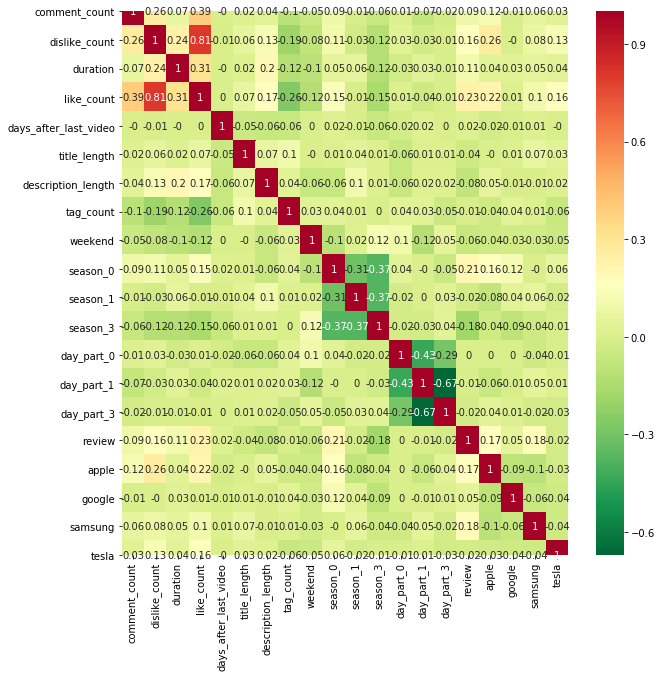

In [22]:
plt.figure(figsize = (10,10))
sns.heatmap(round(X.corr(), 2), cmap = 'RdYlGn_r', annot = True)

In [23]:
X['like_dislike_ratio'] = X['like_count'] / (X['dislike_count'] + X['like_count'])

In [24]:
X.drop(columns = ['like_count','dislike_count'], inplace = True)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [112]:
X_train

,comment_count,duration,days_after_last_video,title_length,description_length,tag_count,weekend,season_0,season_1,season_3,day_part_0,day_part_1,day_part_3,review,apple,google,samsung,tesla,like_dislike_ratio
59,10,195,0,52,178,14,1,0,0,1,0,0,1,0,0,0,0,0,0.914286
13,16,140,0,24,33,6,0,0,0,1,0,0,1,0,0,0,0,0,0.977273
649,5355,1022,3,22,495,18,0,1,0,0,0,1,0,1,0,1,0,0,0.985950
262,59,228,3,42,324,28,0,1,0,0,0,0,1,0,0,0,0,0,0.867769
828,1873,393,2,27,541,9,0,0,0,1,0,0,1,0,0,0,0,0,0.987438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,5680,548,3,29,441,14,0,1,0,0,0,0,1,1,0,0,1,0,0.973699
905,11719,1061,6,43,533,17,0,1,0,0,0,0,1,1,0,1,0,0,0.967256
1096,4173,458,1,46,605,29,0,1,0,0,0,1,0,1,1,0,0,0,0.976709
235,34,208,3,37,112,20,0,0,0,0,0,1,0,0,0,0,0,0,0.899254


In [51]:
X_train_numerical = X_train.drop(columns = ['weekend',
'season_0',
'season_1',        
'season_3',       
'day_part_0',     
'day_part_1',     
'day_part_3',    
'review',   
'apple',  
'google' , 
'samsung',
'tesla'])

X_test_numerical = X_test.drop(columns = ['weekend',
'season_0',
'season_1',        
'season_3',       
'day_part_0',     
'day_part_1',     
'day_part_3',    
'review',   
'apple',  
'google' , 
'samsung',
'tesla'])

X_train_categorical = X_train[['weekend',
'season_0',
'season_1',        
'season_3',       
'day_part_0',     
'day_part_1',     
'day_part_3',    
'review',   
'apple',  
'google' , 
'samsung',
'tesla']]

X_test_categorical = X_test[['weekend',
'season_0',
'season_1',        
'season_3',       
'day_part_0',     
'day_part_1',     
'day_part_3',    
'review',   
'apple',  
'google' , 
'samsung',
'tesla']]


In [69]:
scaler = MinMaxScaler()
X_train_numerical_scaled = pd.DataFrame(scaler.fit_transform(X_train_numerical), columns = X_train_numerical.columns, index = X_train_numerical.index)
X_test_numerical_scaled = pd.DataFrame(scaler.transform(X_test_numerical), columns = X_test_numerical.columns,index = X_test_numerical.index )

In [71]:
X_train_scaled = pd.concat([X_train_numerical_scaled, X_train_categorical], axis = 1)
X_test_scaled = pd.concat([X_test_numerical_scaled, X_test_categorical], axis = 1)

In [72]:
linreg = LinearRegression()
model = linreg.fit(X_train_scaled, y_train)

In [98]:
def train_vs_test(model, X_train, X_test, y_train, y_test):
    
    r_2_train = np.mean(cross_val_score(model, X_train, y_train, cv = 5 ))
    
    y_test_hat = model.predict(X_test)
    r_2_test = r2_score(y_test, y_test_hat)
    
    return print(('The R^2 for the train set is {} \nThe R^2 for the test set is {} '.format(round(r_2_train, 4), round( r_2_test, 4))))
    

In [99]:
train_vs_test(model, X_train_scaled, X_test_scaled, y_train, y_test)

The R^2 for the train set is 0.3401 
The R^2 for the test set is -0.6796 


In [102]:
print(list(zip(X.columns, model.coef_)))

[('comment_count', 6456926.905826063), ('duration', 6794499.293402263), ('days_after_last_video', -454361.3414868727), ('title_length', 244486.0438156195), ('description_length', 1026335.8804083844), ('tag_count', -1569923.2055992186), ('weekend', 95984.5349365838), ('season_0', -9137.58962243406), ('season_1', -8069.718614895394), ('season_3', -226857.50125202563), ('day_part_0', -292941.9560140406), ('day_part_1', 81970.22017289182), ('day_part_3', -42109.98722698258), ('review', 61750.689123111006), ('apple', 688204.2757291639), ('google', 1267364.6528808435), ('samsung', 121750.14165283927), ('tesla', 795983.6093001032), ('like_dislike_ratio', 1016551.0359004624)]


In [105]:
from itertools import combinations
combinations = list(combinations(X.columns, 2))

interactions = []
data = X_train_scaled.copy()
for comb in combinations:
    data["interaction"] = data[comb[0]] * data[comb[1]]
    score = round(np.mean(cross_val_score(linreg, data, y_train, scoring="r2", cv=5)), 4)
    if score > 0.3401: interactions.append((comb[0], comb[1], round(score,3)))
            
print("Top 7 interactions: %s" %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:7])

Top 7 interactions: [('comment_count', 'like_dislike_ratio', 0.479), ('comment_count', 'day_part_3', 0.421), ('comment_count', 'samsung', 0.413), ('comment_count', 'duration', 0.408), ('comment_count', 'season_1', 0.406), ('comment_count', 'weekend', 0.405), ('comment_count', 'day_part_0', 0.4)]


In [114]:
rfe = RFECV(linreg, cv = 5)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)
lm = linreg.fit(X_train_rfe, y_train)

In [115]:
train_vs_test(lm, X_train_rfe, X_test_rfe, y_train, y_test)

The R^2 for the train set is 0.3455 
The R^2 for the test set is -0.7355 
